
# 🧠 Robust Multimodal Emotion & Strategy Classifier (ResNet + Audio + Text)

This notebook includes:
- Balanced CSV loading  
- Safe image/audio reading (graceful failure logging)  
- Debug mode with `num_workers=0`  
- Full train/val loop  
- Save and reload trained model


In [14]:

import os, random, json, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Config
CSV_PATH = 'MESC_cleaned_no_path.csv'
FRAME_COLS = [f'Frame_{i}' for i in range(1,13)]
TEXT_COL, EMOTION_COL, STRATEGY_COL = 'Utterance','Emotion','Strategy'
SAMPLE_RATE, N_MELS = 16000, 128
BATCH_SIZE, EPOCHS, LR = 128, 5, 1e-4
NUM_WORKERS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [15]:

# Load CSV and encode
df = pd.read_csv(CSV_PATH).dropna(subset=[TEXT_COL,EMOTION_COL,STRATEGY_COL,'Audio']+FRAME_COLS)
le_e, le_s = LabelEncoder().fit(df[EMOTION_COL]), LabelEncoder().fit(df[STRATEGY_COL])
df['emotion_id'], df['strategy_id'] = le_e.transform(df[EMOTION_COL]), le_s.transform(df[STRATEGY_COL])
num_emotions, num_strategies = len(le_e.classes_), len(le_s.classes_)
print(num_emotions,"emotions", num_strategies,"strategies")
train_df, val_df = train_test_split(df,test_size=0.15,random_state=42,stratify=df['emotion_id'])


7 emotions 10 strategies


In [16]:

# Safe loaders
def safe_img(path):
    try:
        path=os.path.normpath(path)
        return Image.open(path).convert('L')
    except Exception as e:
        raise RuntimeError(f"Image failed: {path} -> {e}")
import soundfile as sf
import torchaudio.functional as F

def safe_audio(path):
    try:
        path = os.path.normpath(path)
        # Read using libsndfile backend
        wav, sr = sf.read(path, dtype='float32', always_2d=False)
        wav = torch.tensor(wav, dtype=torch.float32)
        if wav.ndim > 1:  # stereo → mono
            wav = wav.mean(dim=-1)
        wav = wav.unsqueeze(0)  # shape [1, T]
        if sr != SAMPLE_RATE:
            wav = F.resample(wav, sr, SAMPLE_RATE)
        return wav
    except Exception as e:
        raise RuntimeError(f"Audio failed: {path} -> {e}")



In [17]:

img_tf=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
melspec=torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,n_mels=N_MELS)
amp2db=torchaudio.transforms.AmplitudeToDB()

class ClipDS(Dataset):
    def __init__(self,df):self.df=df.reset_index(drop=True)
    def __len__(self):return len(self.df)
    def __getitem__(self,i):
        try:
            row=self.df.loc[i]
            fr=[img_tf(safe_img(row[c])) for c in FRAME_COLS]
            wav=safe_audio(row['Audio'])
            mel=amp2db(melspec(wav)).squeeze(0).mean(-1)
            return {'utt':row[TEXT_COL],'frames_12':torch.stack(fr),
                    'audio_feat':mel,'emo':int(row['emotion_id']),'strat':int(row['strategy_id'])}
        except Exception as e:raise RuntimeError(f"Idx {i}: {e}")


C:\Users\Ezaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [18]:

def tok(texts,max_len=64):
    arr=[[ord(c)%10000 for c in t][:max_len] for t in texts]
    L=max(len(a) for a in arr)
    x=torch.zeros(len(arr),L).long()
    for i,a in enumerate(arr):x[i,:len(a)]=torch.tensor(a)
    return x,torch.ones_like(x)
def collate(b):
    ids,att=tok([x['utt'] for x in b])
    fr=torch.stack([x['frames_12'] for x in b])
    au=torch.stack([x['audio_feat'] for x in b])
    e=torch.tensor([x['emo'] for x in b]);s=torch.tensor([x['strat'] for x in b])
    return {'input_ids':ids,'att':att,'frames':fr,'audio':au,'emo':e,'strat':s}

train_dl=DataLoader(ClipDS(train_df),batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate)
val_dl=DataLoader(ClipDS(val_df),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate)
print("Train:",len(train_dl.dataset))


Train: 10639


In [19]:
from typing import Tuple, Dict, Optional
from dataclasses import dataclass

import math
import torch
import torch.nn as nn
from torchvision import models

# -------------------- Vision backbone: MobileNetV3-Small → 576-d features --------------------
def mobilenet_gray():
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    first = m.features[0][0]  # Conv2d inside ConvBNActivation
    w = first.weight.mean(1, keepdim=True).clone()  # [C,1,3,3]
    m.features[0][0] = nn.Conv2d(
        in_channels=1,
        out_channels=first.out_channels,
        kernel_size=first.kernel_size,
        stride=first.stride,
        padding=first.padding,
        bias=False,
    )
    m.features[0][0].weight.data = w
    m.classifier = nn.Identity()
    return m, 576

# -------------------- Text encoder (tiny) --------------------
class TxtEnc(nn.Module):
    def __init__(self, h=512, vocab=10000, nheads=4, nlayers=1):
        super().__init__()
        self.emb = nn.Embedding(vocab, h)
        layer = nn.TransformerEncoderLayer(h, nheads, batch_first=True)
        self.enc = nn.TransformerEncoder(layer, nlayers)

    def forward(self, ids, att):
        x = self.emb(ids)
        seq = self.enc(x, src_key_padding_mask=(att == 0) if att is not None else None)
        cls = seq[:, 0, :]
        return seq, cls  # [B,T,512], [B,512]

# -------------------- Lightweight audio encoder over Mel axis --------------------
class AudioEnc(nn.Module):
    """
    Input:  [B, N_MELS]
    Output: [B, 512]
    """
    def __init__(self, n_mels, d=512, mid_ch=64, se_ratio=8):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, mid_ch, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm1d(mid_ch),
            nn.GELU(),
        )
        self.dw2 = nn.Sequential(
            nn.Conv1d(mid_ch, mid_ch, kernel_size=5, padding=2, groups=mid_ch, bias=False),
            nn.BatchNorm1d(mid_ch),
            nn.GELU(),
        )
        self.pw2 = nn.Sequential(
            nn.Conv1d(mid_ch, mid_ch, kernel_size=1, bias=False),
            nn.BatchNorm1d(mid_ch),
            nn.GELU(),
        )
        se_hidden = max(4, mid_ch // se_ratio)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(mid_ch, se_hidden), nn.GELU(),
            nn.Linear(se_hidden, mid_ch), nn.Sigmoid(),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(mid_ch, d),
        )
        self.n_mels = n_mels

    def forward(self, x):  # x: [B, N_MELS]
        x = x.unsqueeze(1)                 # [B,1,M]
        x = self.conv1(x)                  # [B,C,M]
        y = self.dw2(x); y = self.pw2(y)   # [B,C,M]
        w = self.se(y)                     # [B,C]
        y = y * w.unsqueeze(-1)            # [B,C,M]
        z = self.head(y)                   # [B,512]
        return z

# -------------------- Differentiable (STE) text-guided hard Top-K selector --------------------
class DiffTopKSelector(nn.Module):
    """
    Given:
      - frame feats vf: [B, F, D] (F=12)
      - text CLS       : [B, D]
    Compute scores s = <W_t * cls, W_f * vf> / sqrt(D),
    then produce a HARD top-K mask for forward, and use SOFT weights for gradient (STE).
    Returns pooled frame [B,D], indices [B,K], and aux losses dict.
    """
    def __init__(self, d=512, top_k=6, temperature=0.5, add_entropy_loss=True):
        super().__init__()
        self.f_key   = nn.Linear(d, d, bias=False)
        self.t_query = nn.Linear(d, d, bias=False)
        self.top_k = top_k
        self.tau = temperature
        self.add_entropy_loss = add_entropy_loss
        self._eps = 1e-8

    def forward(self, vf: torch.Tensor, cls: torch.Tensor):
        """
        vf : [B,F,D]
        cls: [B,D]
        """
        B, F, D = vf.shape
        q = self.t_query(cls).unsqueeze(1)         # [B,1,D]
        k = self.f_key(vf)                         # [B,F,D]

        scores = (q * k).sum(-1) / math.sqrt(D)    # [B,F]

        # Soft weights for gradient
        w_soft = torch.softmax(scores / self.tau, dim=-1)  # [B,F]

        # Hard top-K for forward
        topk_vals, topk_idx = scores.topk(self.top_k, dim=1)        # [B,K]
        hard_mask = torch.zeros_like(scores).scatter(1, topk_idx, 1) # one-hot K per row

        # Straight-through estimator
        w_st = (hard_mask - w_soft).detach() + w_soft               # [B,F]

        # Pool frames with average over selected (divide by K to keep scale stable)
        pooled = torch.einsum('bf,bfd->bd', w_st, vf) / self.top_k  # [B,D]

        # Aux losses (optional): encourage peakedness / low entropy
        aux: Dict[str, torch.Tensor] = {}
        if self.add_entropy_loss:
            # entropy over soft weights
            ent = -(w_soft * (w_soft + self._eps).log()).sum(dim=-1).mean()
            aux['selector_entropy'] = ent  # maximize sharpness → minimize entropy, so we'll use -ent in loss
            # margin: mean gap between kth and (k+1)th
            sorted_scores, _ = torch.sort(scores, dim=1, descending=True)
            margin = (sorted_scores[:, self.top_k - 1] - sorted_scores[:, self.top_k]).mean()
            aux['selector_margin'] = margin

        return pooled, topk_idx, aux

# -------------------- Data-conditioned per-channel fusion (GMU-style) --------------------
class FusionGate(nn.Module):
    """
    g = sigmoid(MLP([v, a, t_cls]))  → per-channel gate in R^D
    Optional reliabilities r_v, r_a ∈ (0,1) to modulate contributions.
    """
    def __init__(self, d=512, use_reliability=True, hidden=256):
        super().__init__()
        self.use_reliability = use_reliability
        self.mlp = nn.Sequential(
            nn.Linear(d * 3, hidden), nn.GELU(),
            nn.Linear(hidden, d)
        )
        if use_reliability:
            self.rel_head_v = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())
            self.rel_head_a = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid())

    def forward(self, v, a, t_cls):   # each [B,D]
        x = torch.cat([v, a, t_cls], dim=-1)   # [B,3D]
        g = torch.sigmoid(self.mlp(x))         # [B,D]
        if self.use_reliability:
            # Predict reliabilities from modality features (stop-grad optional)
            rv = self.rel_head_v(v)            # [B,1]
            ra = self.rel_head_a(a)            # [B,1]
            # broadcast to channels
            rv_c = rv.expand_as(g)
            ra_c = ra.expand_as(g)
            # convex weights (sum to 1 channelwise) using sigmoid gate
            av = rv_c * (g * v) + ra_c * ((1.0 - g) * a)   # [B,D]
            reliab = {'r_v': rv.mean(), 'r_a': ra.mean()}
            return av, reliab
        else:
            av = g * v + (1.0 - g) * a
            return av, {}

# -------------------- Full Net --------------------
@dataclass
class NetCfg:
    num_emotions: int
    num_strategies: int
    n_mels: int
    top_k: int = 6
    tau: float = 0.5
    use_reliability: bool = True
    alpha_sparse: float = 0.05     # weight for selector entropy (as negative)
    beta_unc: float = 0.0          # optional KL/entropy regularizer for reliabilities
    cross_heads: int = 8

class Net(nn.Module):
    """
    Frames: [B,12,1,128,128], Mel: [B, N_MELS], Text: {'input_ids':[B,T], 'att':[B,T]}
    Returns:
      emo_logits [B,E], strat_logits [B,S], aux dict (with topk_idx, losses to add)
    """
    def __init__(self, cfg: NetCfg):
        super().__init__()
        self.cfg = cfg

        # Vision
        self.v, v_dim = mobilenet_gray()    # 576
        self.vp = nn.Linear(v_dim, 512)

        # Audio
        self.aenc = AudioEnc(cfg.n_mels, d=512, mid_ch=64, se_ratio=8)

        # Text
        self.t = TxtEnc()

        # Differentiable selector
        self.selector = DiffTopKSelector(d=512, top_k=cfg.top_k, temperature=cfg.tau, add_entropy_loss=True)

        # Fusion (data-conditioned)
        self.fuse = FusionGate(d=512, use_reliability=cfg.use_reliability)

        # Cross-attn (text queries → fused AV as single token)
        self.q = nn.Linear(512, 512)
        self.k = nn.Linear(512, 512)
        self.vv = nn.Linear(512, 512)
        self.att = nn.MultiheadAttention(512, cfg.cross_heads, batch_first=True)

        # Heads
        self.he = nn.Linear(512, cfg.num_emotions)
        self.hs = nn.Linear(512, cfg.num_strategies)

    def forward(self, fr, au, t) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        """
        fr: [B,12,1,128,128]
        au: [B, N_MELS]
        t : dict with 'input_ids':[B,T], 'att':[B,T]
        """
        B = fr.size(0)

        # ---- Text ----
        seq, cls = self.t(t['input_ids'], t.get('att', None))     # [B,T,512], [B,512]

        # ---- Vision (per frame) ----
        vf = self.v(fr.view(B * 12, 1, 128, 128))                 # [B*12,576]
        vf = self.vp(vf).view(B, 12, 512)                         # [B,12,512]

        # ---- Selector: text-guided hard top-K with soft grad ----
        v_pooled, topk_idx, sel_aux = self.selector(vf, cls)      # [B,512], [B,K], dict

        # ---- Audio ----
        a = self.aenc(au)                                         # [B,512]

        # ---- Data-conditioned fusion ----
        av, rel = self.fuse(v_pooled, a, cls)                     # [B,512], reliab stats
        av_tok = av.unsqueeze(1)                                  # [B,1,512]

        # ---- Cross-attention ----
        qx, kx, vx = self.q(seq), self.k(av_tok), self.vv(av_tok)
        o, _ = self.att(qx, kx, vx)                               # [B,T,512]
        fz = o[:, 0, :]                                           # [B,512]

        # ---- Predictions ----
        emo = self.he(fz)
        strat = self.hs(fz)

        # ---- Aux losses to add in training ----
        aux_losses = {}
        if 'selector_entropy' in sel_aux:
            # Minimize entropy → add -entropy (so larger weight encourages peaky selection)
            aux_losses['loss_selector_entropy'] = -sel_aux['selector_entropy'] * self.cfg.alpha_sparse
            # Encourage positive margin (optional – maximize margin → minimize negative)
            aux_losses['loss_selector_margin'] = -0.01 * sel_aux['selector_margin']

        if self.cfg.use_reliability and self.cfg.beta_unc > 0.0:
            # Optional regularizer to keep reliabilities non-degenerate (close to 0.5)
            # L_unc = ( (r-0.5)^2 ).mean()
            r_v = rel.get('r_v', torch.tensor(0.5, device=emo.device))
            r_a = rel.get('r_a', torch.tensor(0.5, device=emo.device))
            l_unc = ((r_v - 0.5).pow(2) + (r_a - 0.5).pow(2)).mean()
            aux_losses['loss_uncert'] = self.cfg.beta_unc * l_unc

        aux = {'topk_idx': topk_idx, **aux_losses}
        return emo, strat, aux








In [20]:
# Define your configuration first
cfg = NetCfg(
    num_emotions=num_emotions,     # replace with your actual numbers
    num_strategies=num_strategies,
    n_mels=N_MELS,
    top_k=6,
    tau=0.5,
    use_reliability=True,
    alpha_sparse=0.05,
    beta_unc=0.0
)

# Then create the model with the config
model = Net(cfg).to(device)
model.load_state_dict(torch.load("robust_avt_model3.pth", map_location=device))
opt = torch.optim.AdamW(model.parameters(), lr=LR)
ce = nn.CrossEntropyLoss()


In [21]:
from tqdm import tqdm
import torch

def run_epoch(model, dl, train=True, track_frames=False):
    """
    train         : toggles model.train()/eval() and grad
    track_frames  : if True, returns a histogram of how often each frame idx (0..11) was selected
    """
    model.train(train)
    total_emo_loss, total_str_loss = 0.0, 0.0
    correct_emo, correct_str = 0, 0
    total_samples = 0

    # optional frame-selection tracking
    frame_hist = torch.zeros(12, dtype=torch.long) if track_frames else None

    phase = "Train" if train else "Val"
    pbar = tqdm(dl, desc=f"{phase} epoch", leave=False)

    for batch in pbar:
        # ---------------- Inputs ----------------
        frames = batch['frames'].to(device)           # [B,12,1,128,128]
        audio  = batch['audio'].to(device)            # [B, N_MELS]
        emo_gt = batch['emo'].to(device)              # [B]
        strat_gt = batch['strat'].to(device)          # [B]
        text = {
            'input_ids': batch['input_ids'].to(device),   # [B,T]
            'att': batch['att'].to(device)                # [B,T]
        }

        # ---------------- Forward / Backward ----------------
        with torch.set_grad_enabled(train):
            # NEW: model returns (emo_pred, strat_pred, aux)
            emo_pred, strat_pred, aux = model(frames, audio, text)

            # base losses
            loss_emo = ce(emo_pred, emo_gt)
            loss_str = ce(strat_pred, strat_gt)
            total_loss = loss_emo + loss_str

            # add any auxiliary losses provided by the model
            if isinstance(aux, dict):
                for k, v in aux.items():
                    if k.startswith('loss_'):
                        total_loss = total_loss + v  # aux losses already scaled inside the model

            if train:
                opt.zero_grad(set_to_none=True)
                total_loss.backward()
                opt.step()

        # ---------------- Metrics ----------------
        bs = frames.size(0)
        total_samples += bs
        total_emo_loss += loss_emo.item() * bs
        total_str_loss += loss_str.item() * bs
        correct_emo += (emo_pred.argmax(1) == emo_gt).sum().item()
        correct_str += (strat_pred.argmax(1) == strat_gt).sum().item()

        # track which frame positions are being picked (only if requested)
        if track_frames and isinstance(aux, dict) and ('topk_idx' in aux):
            # aux['topk_idx'] is [B,K]; count occurrences per position 0..11
            sel = aux['topk_idx'].detach().reshape(-1).to('cpu')
            counts = torch.bincount(sel, minlength=12)
            frame_hist += counts.to(frame_hist.dtype)

        # live display
        pbar.set_postfix({
            "EmoLoss": f"{loss_emo.item():.3f}",
            "StrLoss": f"{loss_str.item():.3f}"
        })

    avg_emo_loss = total_emo_loss / max(1, total_samples)
    avg_str_loss = total_str_loss / max(1, total_samples)
    emo_acc = correct_emo / max(1, total_samples)
    strat_acc = correct_str / max(1, total_samples)

    out = {
        "emo_loss": avg_emo_loss,
        "emo_acc": emo_acc,
        "str_loss": avg_str_loss,
        "str_acc": strat_acc
    }
    if track_frames and frame_hist is not None:
        out["topk_hist"] = frame_hist.tolist()  # length-12 list for convenience
    return out


# ---------------- Training Loop ----------------
history = []
for ep in range(1, EPOCHS + 1):  # <- use your global EPOCHS consistently
    print(f"\n🟩 Epoch {ep}/{EPOCHS}")
    train_metrics = run_epoch(model, train_dl, train=True,  track_frames=False)
    val_metrics   = run_epoch(model, val_dl,   train=False, track_frames=True)  # track on val

    print(f"📊 Train — "
          f"Emotion Loss: {train_metrics['emo_loss']:.4f}, "
          f"Acc: {train_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {train_metrics['str_loss']:.4f}, "
          f"Acc: {train_metrics['str_acc']*100:.2f}%")

    print(f"🧪 Val   — "
          f"Emotion Loss: {val_metrics['emo_loss']:.4f}, "
          f"Acc: {val_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {val_metrics['str_loss']:.4f}, "
          f"Acc: {val_metrics['str_acc']*100:.2f}%")

    if 'topk_hist' in val_metrics:
        hist = val_metrics['topk_hist']
        print(f"🎯 Val frame-selection histogram (idx 0..11): {hist}")

    history.append((train_metrics, val_metrics))



🟩 Epoch 1/5


📊 Train — Emotion Loss: 0.0123, Acc: 99.62% | Strategy Loss: 0.0314, Acc: 98.98%
🧪 Val   — Emotion Loss: 0.0527, Acc: 99.31% | Strategy Loss: 0.1317, Acc: 98.08%
🎯 Val frame-selection histogram (idx 0..11): [937, 924, 909, 943, 929, 906, 966, 1008, 935, 955, 917, 939]

🟩 Epoch 2/5


📊 Train — Emotion Loss: 0.0067, Acc: 99.80% | Strategy Loss: 0.0264, Acc: 99.02%
🧪 Val   — Emotion Loss: 0.0484, Acc: 99.47% | Strategy Loss: 0.1187, Acc: 98.14%
🎯 Val frame-selection histogram (idx 0..11): [898, 958, 943, 907, 956, 908, 962, 1016, 915, 974, 879, 952]

🟩 Epoch 3/5


📊 Train — Emotion Loss: 0.0145, Acc: 99.61% | Strategy Loss: 0.0213, Acc: 99.23%
🧪 Val   — Emotion Loss: 0.0309, Acc: 99.52% | Strategy Loss: 0.1098, Acc: 98.03%
🎯 Val frame-selection histogram (idx 0..11): [945, 905, 951, 896, 1015, 980, 943, 992, 908, 915, 915, 903]

🟩 Epoch 4/5


📊 Train — Emotion Loss: 0.0284, Acc: 99.23% | Strategy Loss: 0.0419, Acc: 98.65%
🧪 Val   — Emotion Loss: 0.0281, Acc: 99.63% | Strategy Loss: 0.1276, Acc: 97.66%
🎯 Val frame-selection histogram (idx 0..11): [889, 937, 900, 959, 953, 1017, 972, 947, 960, 908, 924, 902]

🟩 Epoch 5/5


📊 Train — Emotion Loss: 0.0060, Acc: 99.88% | Strategy Loss: 0.0212, Acc: 99.10%
🧪 Val   — Emotion Loss: 0.0472, Acc: 99.31% | Strategy Loss: 0.1412, Acc: 98.14%
🎯 Val frame-selection histogram (idx 0..11): [939, 942, 944, 904, 962, 999, 972, 946, 930, 927, 915, 888]


In [22]:
# save + consistent message
save_path = "robust_avt_model3.pth"
torch.save(model.state_dict(), save_path)
print(f"\n✅ Model saved as {save_path}")


✅ Model saved as robust_avt_model3.pth


In [23]:
from PIL import Image
import torch

def predict_sample(model, frame_paths, audio_path, utterance, le_emotion, le_strategy):
    """
    frame_paths: list of 12 grayscale 128x128 image paths
    audio_path : path to WAV file
    utterance  : text (string)
    le_emotion, le_strategy: trained label encoders

    Returns:
        emotion (str), strategy (str),
        selected_idx (list[int]), selected_paths (list[str])
    """

    # --- Preprocess frames ---
    frames = [img_tf(safe_img(p)) for p in frame_paths]     # each -> [1,128,128]
    frames = torch.stack(frames).unsqueeze(0).to(device)    # [1,12,1,128,128]

    # --- Preprocess audio ---
    wav = safe_audio(audio_path)
    mel = amp2db(melspec(wav)).squeeze(0).mean(-1)         # [N_MELS]
    mel = mel.unsqueeze(0).to(device)                      # [1, N_MELS]

    # --- Text tokens ---
    ids, att = tok([utterance])
    text = {'input_ids': ids.to(device), 'att': att.to(device)}

    # --- Forward pass ---
    with torch.no_grad():
        emo_pred, strat_pred, aux = model(frames, mel, text)  # aux is a dict
        emo_id   = emo_pred.argmax(1).item()
        strat_id = strat_pred.argmax(1).item()

        # get top-k indices from aux (fallback to empty list if not present)
        if isinstance(aux, dict) and ('topk_idx' in aux):
            topk_idx = aux['topk_idx']                        # [1,K]
            selected_idx = topk_idx[0].tolist()
        else:
            selected_idx = []  # no selector info available

        selected_paths = [frame_paths[i] for i in selected_idx] if selected_idx else []

    # --- Decode labels ---
    emotion = le_emotion.inverse_transform([emo_id])[0]
    strategy = le_strategy.inverse_transform([strat_id])[0]

    # --- Logs ---
    print(f"🧩 Predicted Emotion:  {emotion}")
    print(f"🗣️  Predicted Strategy: {strategy}")
    if selected_idx:
        print(f"🎯 Selected frames (by relevance score, desc): {selected_idx}")
        print("    Paths:")
        for i in selected_idx:
            print(f"     - [{i}] {frame_paths[i]}")
    else:
        print("ℹ️  No top-K frame indices available from model aux.")

    return emotion, strategy, selected_idx, selected_paths


In [24]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def show_prediction_sample(model, df, le_emotion, le_strategy):
    """
    Randomly picks one row from df, visualizes 12 frames (highlighting the
    model-selected frames), plays audio, shows utterance, and prints predicted
    + true labels. Also shows a second grid with only the selected frames in
    temporal order.
    """

    row = df.sample(1).iloc[0]
    frame_paths = [row[f] for f in FRAME_COLS]
    audio_path  = row['Audio']
    utterance   = row['Utterance']

    print("="*90)
    print(f"🎬 Utterance: {utterance}")
    print(f"🎧 Audio: {audio_path}")
    print("="*90)

    # --- Run prediction first (so we know which frames to highlight) ---
    pred_emotion, pred_strategy, selected_idx, selected_paths = predict_sample(
        model,
        frame_paths=frame_paths,
        audio_path=audio_path,
        utterance=utterance,
        le_emotion=le_emotion,
        le_strategy=le_strategy
    )
    sel_set = set(selected_idx)  # for quick lookup

    # --- Display all 12 frames, highlighting selected ones ---
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, (ax, path) in enumerate(zip(axes.flatten(), frame_paths)):
        try:
            img = Image.open(path).convert("L")
            ax.imshow(img, cmap='gray')
            is_sel = (i in sel_set)
            title = f"Frame {i} {'✓' if is_sel else ''}"
            ax.set_title(title, fontsize=10)
            # highlight selected frames with a thicker red border
            for spine in ax.spines.values():
                spine.set_linewidth(3.0 if is_sel else 0.5)
                spine.set_edgecolor('red' if is_sel else 'black')
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center')
            ax.axis("off")
    plt.tight_layout()
    plt.show()

    # --- Show only selected frames (in temporal order) ---
    if len(selected_idx) > 0:
        sel_temporal = sorted(selected_idx)
        rows = 2
        cols = (len(sel_temporal) + 1) // 2  # 2 rows layout
        fig2, axes2 = plt.subplots(rows, cols, figsize=(3.5*cols, 6))
        axes2 = axes2 if isinstance(axes2, (list, np.ndarray)) else [axes2]
        axes2 = [ax for row_axes in (axes2 if isinstance(axes2, np.ndarray) else [axes2]) 
                 for ax in (row_axes if isinstance(row_axes, np.ndarray) else [row_axes])]
        for j, ax in enumerate(axes2):
            if j < len(sel_temporal):
                idx = sel_temporal[j]
                try:
                    img = Image.open(frame_paths[idx]).convert("L")
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Selected Frame {idx}", fontsize=10)
                    for spine in ax.spines.values():
                        spine.set_linewidth(3.0)
                        spine.set_edgecolor('red')
                    ax.axis("off")
                except Exception:
                    ax.text(0.5, 0.5, "Missing", ha='center', va='center')
                    ax.axis("off")
            else:
                ax.axis("off")
        plt.tight_layout()
        plt.show()

    # --- Play audio ---
    print("🔊 Playing audio:")
    display(Audio(audio_path, autoplay=False))

    # --- Labels (pred vs. true) ---
    true_emotion  = row[EMOTION_COL]
    true_strategy = row[STRATEGY_COL]
    print("\n================= RESULT SUMMARY =================")
    print(f"🧩 Predicted Emotion:  {pred_emotion}")
    print(f"🗣️  Predicted Strategy: {pred_strategy}")
    print(f"🎯 True Emotion:        {true_emotion}")
    print(f"🎯 True Strategy:       {true_strategy}")
    print(f"🎯 Selected frames (by score desc): {selected_idx}")
    print(f"🕒 Selected frames (temporal order): {sorted(selected_idx)}")
    print("===================================================")

    return row, selected_idx, selected_paths


🎬 Utterance: No, it's bullshit. Now I gotta come and deal with this? I got you coming at me like this? That was the tip of the iceberg. My shitty week started on saturday.
🎧 Audio: audio\Dialogue_ID-211_Season-1_Episode-17_00-05-37.998_00-05-49.044.wav
🧩 Predicted Emotion:  disgust
🗣️  Predicted Strategy: Restatement
🎯 Selected frames (by relevance score, desc): [9, 3, 4, 8, 7, 2]
    Paths:
     - [9] frames\Dialogue_ID-211_Season-1_Episode-17_f10_t000346495.png
     - [3] frames\Dialogue_ID-211_Season-1_Episode-17_f04_t000341397.png
     - [4] frames\Dialogue_ID-211_Season-1_Episode-17_f05_t000342246.png
     - [8] frames\Dialogue_ID-211_Season-1_Episode-17_f09_t000345645.png
     - [7] frames\Dialogue_ID-211_Season-1_Episode-17_f08_t000344796.png
     - [2] frames\Dialogue_ID-211_Season-1_Episode-17_f03_t000340547.png


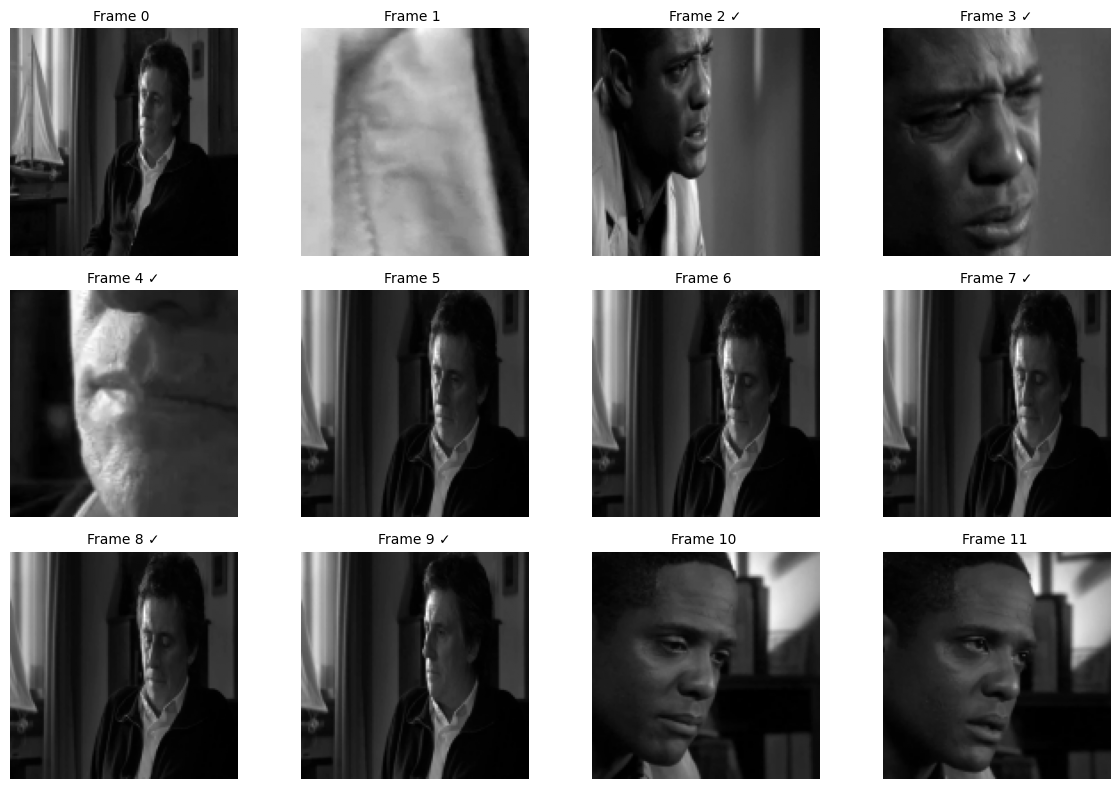

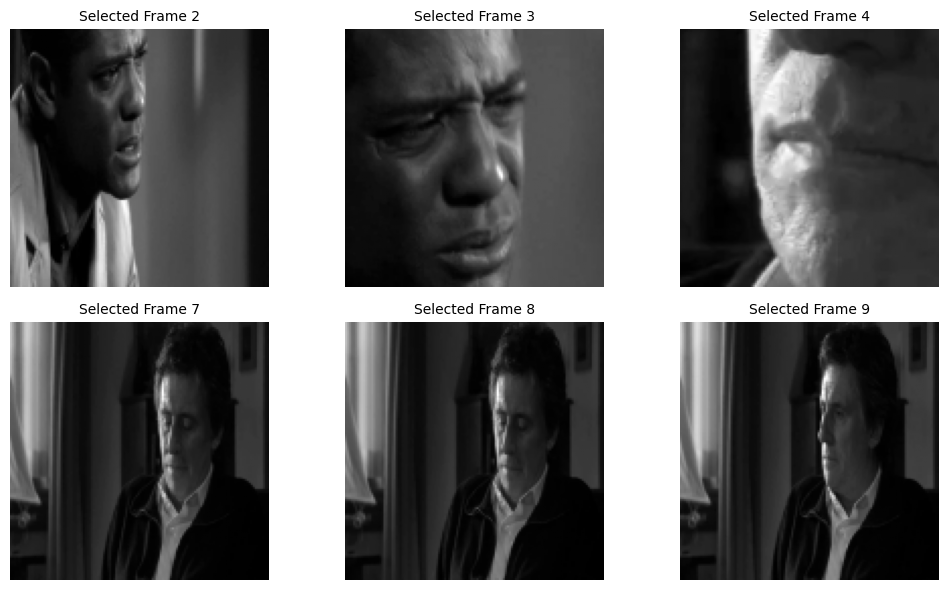

🔊 Playing audio:



================= RESULT SUMMARY =================
🧩 Predicted Emotion:  disgust
🗣️  Predicted Strategy: Restatement
🎯 True Emotion:        disgust
🎯 True Strategy:       Restatement
🎯 Selected frames (by score desc): [9, 3, 4, 8, 7, 2]
🕒 Selected frames (temporal order): [2, 3, 4, 7, 8, 9]


(Dialogue_ID                                                   211
 split_group                                                     2
 Season                                                          1
 Episode                                                        17
 StartTime                                            00:05:37,998
 EndTime                                              00:05:49,044
 Speaker                                                    Client
 Utterance       No, it's bullshit. Now I gotta come and deal w...
 Emotion                                                   disgust
 Strategy                                              Restatement
 Utterance_ID                                                   29
 Frame_1         frames\Dialogue_ID-211_Season-1_Episode-17_f01...
 Frame_2         frames\Dialogue_ID-211_Season-1_Episode-17_f02...
 Frame_3         frames\Dialogue_ID-211_Season-1_Episode-17_f03...
 Frame_4         frames\Dialogue_ID-211_Season-1_Episode-17_f0

In [25]:

# Load trained model and encoders first (if not already)
model_loaded = Net(cfg).to(device)
model_loaded.load_state_dict(torch.load("robust_avt_model3.pth", map_location=device))
model_loaded.eval()

# Now predict on a random CSV row
show_prediction_sample(model_loaded, df, le_e, le_s)

